In [17]:
import requests
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from collections import Counter

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [18]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pranjalpatel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pranjalpatel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pranjalpatel/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [19]:
BASE_URL = "https://api.genius.com"
TOKEN = "11BRBOnSjXPw6wm55lMFu7vj3xFHpYZLMazgP7CSeBThE3QkI9T0nARQIZOFMqEV"
HEADERS = {"Authorization": f"Bearer {TOKEN}"}

In [20]:
def search_artist(artist_name):
    url = f"{BASE_URL}/search"
    params = {"q": artist_name}
    response = requests.get(url, headers=HEADERS, params=params).json()
    hits = response['response']['hits']
    for hit in hits:
        if hit['result']['primary_artist']['name'].lower() == artist_name.lower():
            return hit['result']['primary_artist']['id']
    return None

In [21]:
def get_artist_songs(artist_id, per_page=50, max_pages=5):
    songs = []
    for page in range(1, max_pages+1):
        url = f"{BASE_URL}/artists/{artist_id}/songs"
        params = {"per_page": per_page, "page": page}
        response = requests.get(url, headers=HEADERS, params=params).json()
        songs += response['response']['songs']
    return songs

In [22]:
def get_lyrics(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    lyrics = soup.find('div', class_=re.compile('Lyrics__Container'))
    if lyrics:
        return lyrics.get_text(separator=" ")
    return ""

In [23]:
artists = ["Taylor Swift", "Drake", "Billie Eilish", "Kanye West"]

In [24]:
all_songs = []

for artist in artists:
    artist_id = search_artist(artist)
    songs = get_artist_songs(artist_id, per_page=50, max_pages=2)  # limit to 100 songs
    for song in songs:
        lyrics = get_lyrics(song['url'])
        all_songs.append({
            'artist': artist,
            'title': song['title'],
            'album': song.get('album', {}).get('name', None),
            'release_date': song.get('release_date', None),
            'lyrics': lyrics
        })

df = pd.DataFrame(all_songs)


In [25]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)  # remove brackets
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['clean_lyrics'] = df['lyrics'].apply(clean_text)

In [26]:
stop_words = set(stopwords.words('english'))

def get_features(text):
    words = word_tokenize(text)
    words_no_stop = [w for w in words if w not in stop_words]
    unique_words = len(set(words_no_stop))
    total_words = len(words_no_stop)
    avg_word_len = np.mean([len(w) for w in words_no_stop]) if total_words > 0 else 0
    return pd.Series({'total_words': total_words, 'unique_words': unique_words, 'avg_word_len': avg_word_len})

df = df.join(df['clean_lyrics'].apply(get_features))

In [27]:
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['clean_lyrics'].apply(lambda x: sia.polarity_scores(x)['compound'])


In [28]:
# Summary stats by artist
summary = df.groupby('artist')[['total_words', 'unique_words', 'avg_word_len', 'sentiment']].mean()
print(summary)

# Top 10 most common words per artist
def top_words(text, n=10):
    words = [w for w in word_tokenize(text) if w not in stop_words]
    return Counter(words).most_common(n)

for artist in artists:
    artist_text = " ".join(df[df['artist']==artist]['clean_lyrics'])
    print(f"Top words for {artist}: {top_words(artist_text)}")


               total_words  unique_words  avg_word_len  sentiment
artist                                                           
Billie Eilish    82.072165     59.195876      5.168036  -0.201897
Drake           134.691489     96.382979      5.417311   0.160520
Kanye West      136.895349     93.976744      5.186820   0.231858
Taylor Swift    113.163043     82.065217      5.477612   0.349001
Top words for Taylor Swift: [('like', 173), ('th', 146), ('usa', 116), ('im', 105), ('lyrics', 99), ('time', 97), ('oh', 94), ('love', 84), ('one', 78), ('know', 77)]
Top words for Drake: [('im', 269), ('like', 211), ('got', 174), ('yeah', 140), ('get', 136), ('dont', 107), ('shit', 106), ('know', 104), ('lyrics', 99), ('thats', 97)]
Top words for Billie Eilish: [('guy', 239), ('im', 216), ('like', 179), ('bad', 159), ('youre', 120), ('lyrics', 118), ('know', 102), ('type', 102), ('dont', 93), ('billie', 81)]
Top words for Kanye West: [('like', 205), ('im', 163), ('got', 148), ('know', 131), ('yea

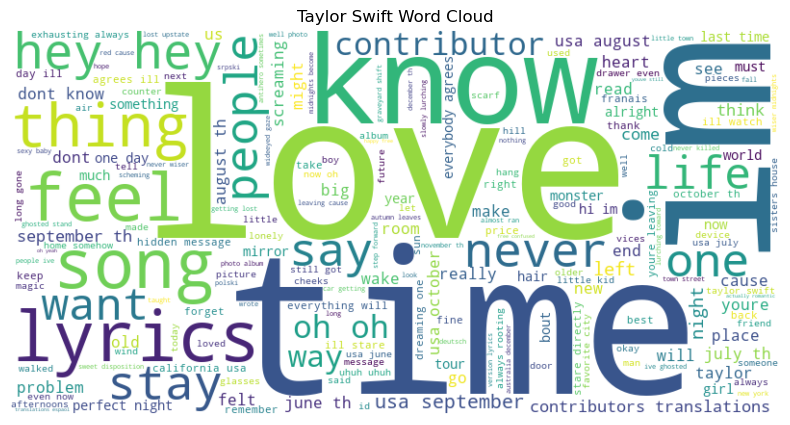

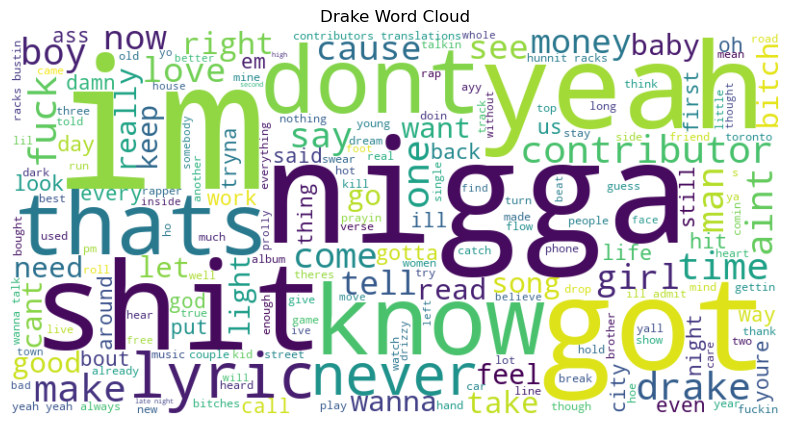

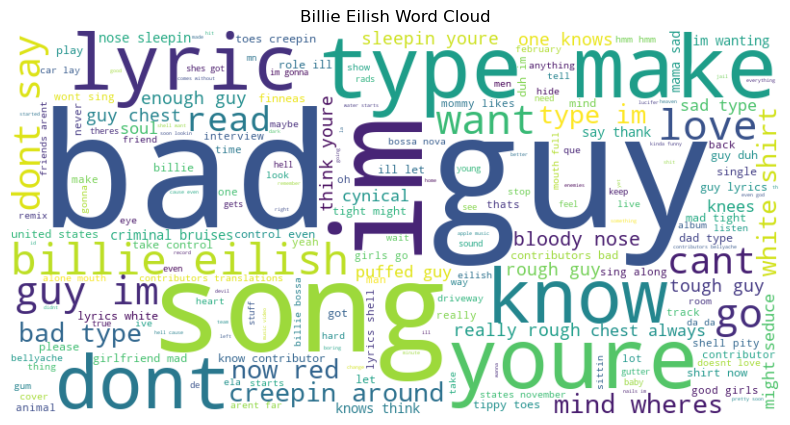

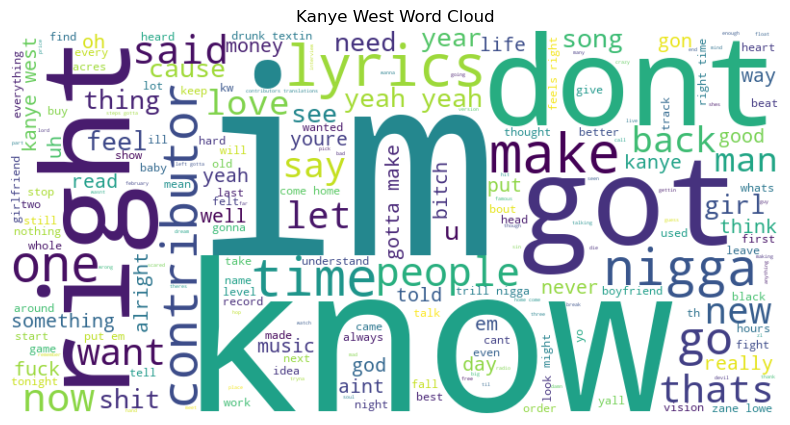

In [32]:
# Word clouds
for artist in artists:
    artist_text = " ".join(df[df['artist']==artist]['clean_lyrics'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(artist_text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{artist} Word Cloud")
    plt.show()



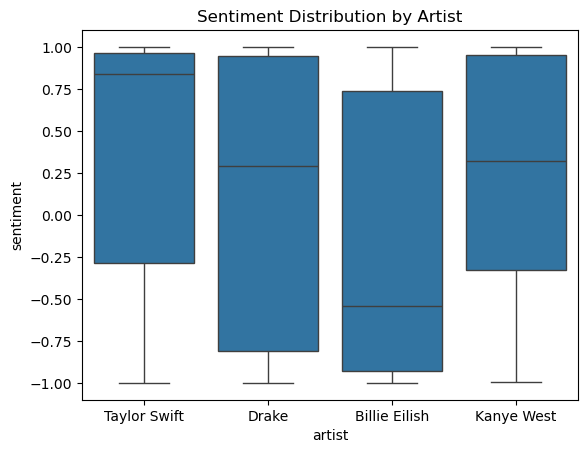

In [31]:
# Boxplot of sentiment
sns.boxplot(x='artist', y='sentiment', data=df)
plt.title("Sentiment Distribution by Artist")
plt.show()

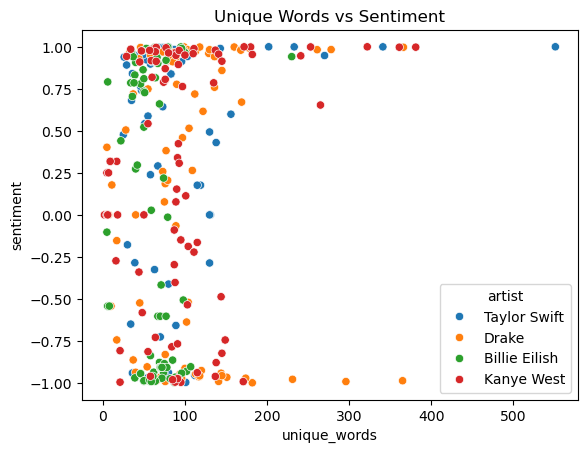

In [30]:
# Scatter plot: Unique words vs sentiment
sns.scatterplot(x='unique_words', y='sentiment', hue='artist', data=df)
plt.title("Unique Words vs Sentiment")
plt.show()

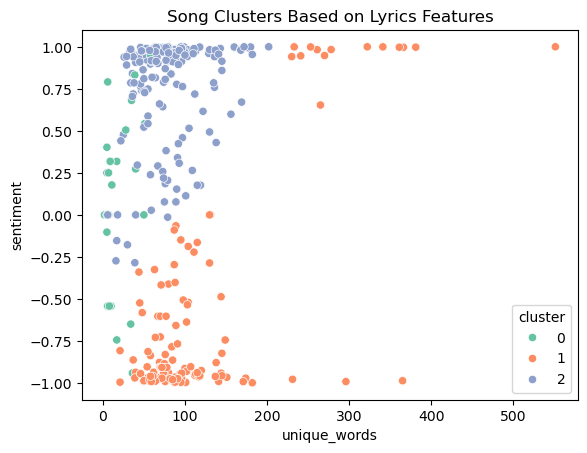

In [33]:
features = df[['total_words', 'unique_words', 'avg_word_len', 'sentiment']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters
sns.scatterplot(x='unique_words', y='sentiment', hue='cluster', palette='Set2', data=df)
plt.title("Song Clusters Based on Lyrics Features")
plt.show()
